In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#%matplotlib inline
# reading the dataset
blobs = pd.read_csv('data.csv')
colnames = list(blobs.columns[1:-1])
print(blobs.head())

   ID       x       y  cluster
0   0  24.412  32.932        2
1   1  35.190  12.189        1
2   2  26.288  41.718        2
3   3   0.376  15.506        0
4   4  26.116   3.963        1


# K-Means

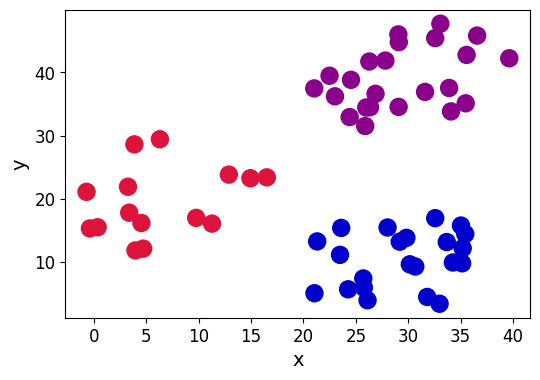

In [252]:
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])

fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(x=blobs['x'], y=blobs['y'], s=150,
            c=blobs['cluster'].astype('category'),
            cmap=customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [238]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

np.random.seed(42)
k = 3
df = blobs[['x', 'y']]
centroids = initiate_centroids(k, df)
print(centroids)

         x       y
0   24.412  32.932
5   25.893  31.515
36  26.878  36.609


In [239]:
def rsserr(a, b):
    '''
    Calculate the root of sum of squared errors.
    a and b are numpy arrays
    '''
    return np.sum(np.square(a - b))

for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid, :], df.iloc[36, :])
    print('Error for centroid {0}: {1:.2f}'.format(i, err))

Error for centroid 0: 19.60
Error for centroid 1: 26.92
Error for centroid 2: 0.00


In [240]:
def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid.
    - dset: pandas dataframe with observations
    - centroids: pandas dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs, :])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid = np.where(all_errors == np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

In [241]:
df.loc[:, 'centroid'], df.loc[:, 'error'] = centroid_assignation(df, centroids)
print(df.head())

        x       y  centroid       error
0  24.412  32.932         0    0.000000
1  35.190  12.189         1  459.928485
2  26.288  41.718         2   26.449981
3   0.376  15.506         0  881.394772
4  26.116   3.963         1  759.162433


C:\Users\Admin\AppData\Local\Temp\ipykernel_17556\765806957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'centroid'], df.loc[:, 'error'] = centroid_assignation(df, centroids)


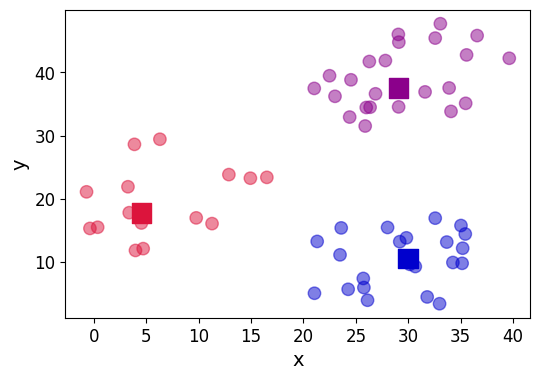

In [256]:
def plot(df, centroids):
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.scatter(df.iloc[:,0], df.iloc[:,1], marker = 'o',
                c=df['centroid'].astype('category'),
                cmap = customcmap, s=80, alpha=0.5)
    plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],
                marker = 's', s=200, c=[0, 1, 2],
                cmap = customcmap)
    ax.set_xlabel(r'x', fontsize=14)
    ax.set_ylabel(r'y', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

plot(df, centroids)

In [243]:
print("The total error is {0:.2f}".format(df['error'].sum()))

The total error is 20611.19


           x          y
0   9.889444  23.242611
1  28.435750  11.546250
2  30.781722  40.310611


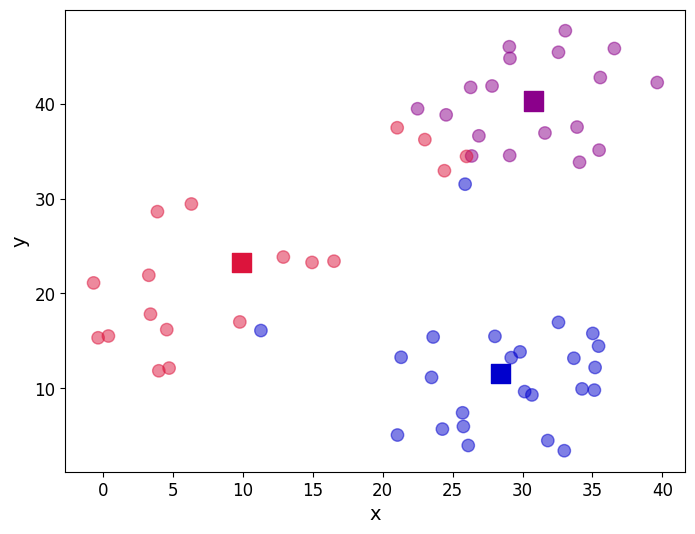

In [244]:
centroids = df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop=True)
print(centroids)
plot(df, centroids)

        x       y  centroid      error
0  24.412  32.932         2  61.546977
1  35.190  12.189         1  37.415091
2  26.288  41.718         2  16.324426
3   0.376  15.506         0  51.798518
4  26.116   3.963         1  52.188602
           x          y
0   6.322867  19.559800
1  29.330864  10.432409
2  29.322478  39.050348


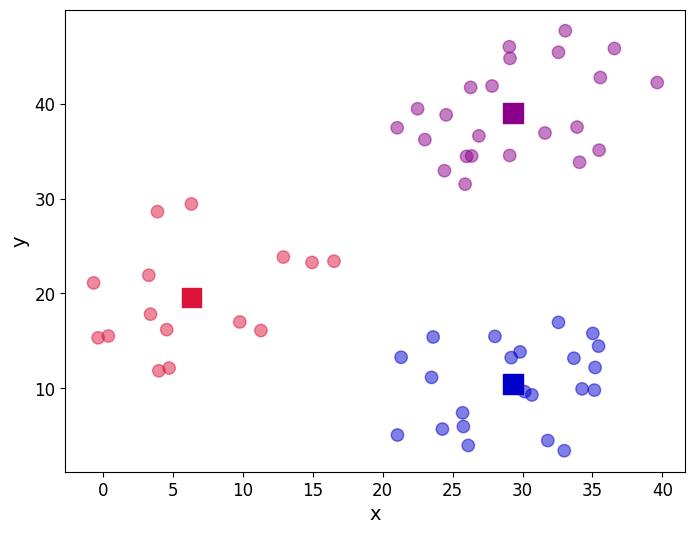

In [245]:
def kmeans(dset, k, tol=1e-4):
    working_dset = dset.copy()
    err = []
    goahead = True
    j = 0
    centroids = initiate_centroids(k, dset)
    while goahead:
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
        err.append(sum(j_err))
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop=True)
        if j > 0:
            if err[j-1] - err[j] <= tol:    
                goahead = False
        j += 1
    return working_dset['centroid'], j_err, centroids

np.random.seed(42)
df['centroid'], df['error'], centroids = kmeans(df[['x', 'y']], k=3)
print(df.head())
print(centroids)
plot(df, centroids)

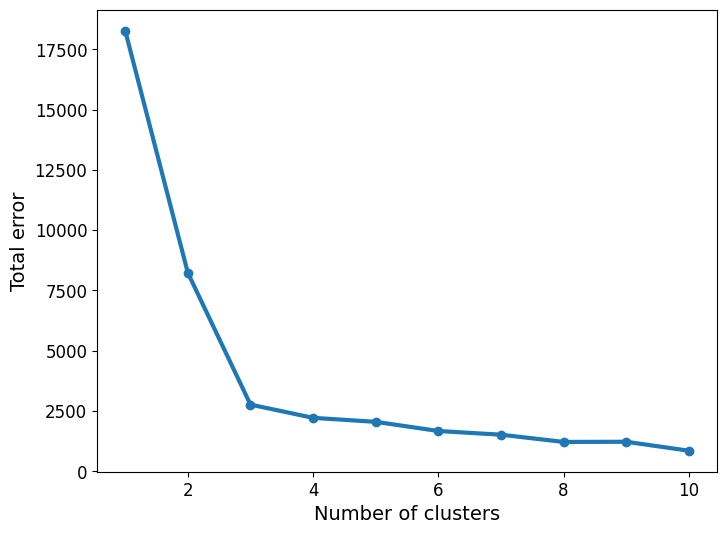

In [246]:
err_total = []
n = 10

df_elbow = blobs[['x','y']]

for i in range(n):
    _, my_errs, _ = kmeans(df_elbow, i+1)
    err_total.append(sum(my_errs))

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel(r'Number of clusters', fontsize=14)
ax.set_ylabel(r'Total error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# K-Medians

In [247]:
def rserr(a, b):
    '''
    Calculate the root of sum of abs errors.
    a and b are numpy arrays
    '''
    return np.sum(np.abs(a - b))

In [248]:
def centroid_assignation_kmedians(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid.
    - dset: pandas dataframe with observations
    - centroids: pandas dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rserr(centroids.iloc[centroid, :], dset.iloc[obs, :])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid = np.where(all_errors == np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

        x       y  centroid    error
0  24.412  32.932         2   9.2470
1  35.190  12.189         1   6.8565
2  26.288  41.718         2   6.9510
3   0.376  15.506         0   6.4780
4  26.116   3.963         1  10.4435
        x        y
0   4.550  17.8100
1  29.986  10.5365
2  29.056  37.5350


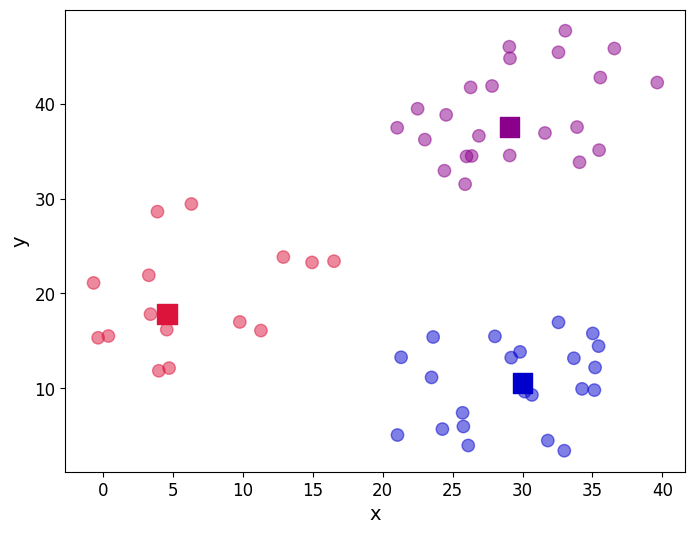

In [249]:
def kmedians(dset, k, tol=1e-4):
    working_dset = dset.copy()
    err = []
    goahead = True
    j = 0
    centroids = initiate_centroids(k, dset)
    while goahead:
        working_dset['centroid'], j_err = centroid_assignation_kmedians(working_dset, centroids)
        err.append(sum(j_err))
        centroids = working_dset.groupby('centroid').agg('median').reset_index(drop=True)
        if j > 0:
            if err[j-1] - err[j] <= tol:    
                goahead = False
        j += 1
    return working_dset['centroid'], j_err, centroids

np.random.seed(42)
df['centroid'], df['error'], centroids = kmedians(df[['x', 'y']], k=3)
print(df.head())
print(centroids)
plot(df, centroids)

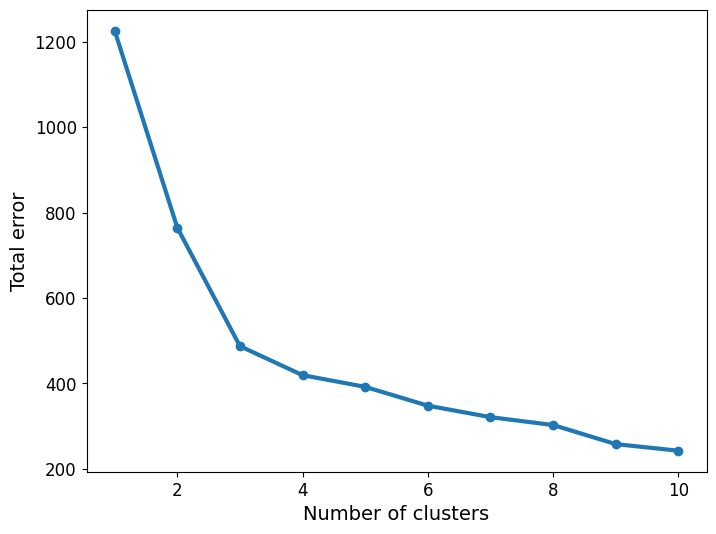

In [250]:
err_total = []
n = 10

df_elbow = blobs[['x','y']]

for i in range(n):
    _, my_errs, _ = kmedians(df_elbow, i+1)
    err_total.append(sum(my_errs))

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel(r'Number of clusters', fontsize=14)
ax.set_ylabel(r'Total error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()